<b>Important:</b> Save prepared/modified datasets locally to <code>../data/prepared/</code>


In [18]:
import sys
import pandas as pd
import numpy as np
sys.path.insert(1, '../../../../utils')
from numpy import log, ndarray, array
from pandas import read_csv, DataFrame, Series, concat
from matplotlib.pyplot import figure, savefig, show, subplots
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from dslabs_functions import evaluate_approach, plot_multiline_chart, plot_bar_chart, get_variable_types, plot_multibar_chart, define_grid, derive_date_variables, HEIGHT, plot_multi_scatters_chart, dummify, CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_evaluation_results, run_NB, run_KNN
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
filename = "../../data/prepared/flight_mvi.csv"
data: DataFrame = read_csv(filename, na_values="")
print("Full MVI shape:", data.shape)

Full MVI shape: (200000, 44)


In [3]:
# keep time ordering consistent with previous notebooks
data = data.sort_values("FlightDate").reset_index(drop=True)

# temporal split 70/30 (we'll only use train for outlier profiling)
split_idx = int(0.7 * len(data))
train_raw = data.iloc[:split_idx].copy()
test_raw  = data.iloc[split_idx:].copy()

print("Train/Test shapes:", train_raw.shape, test_raw.shape)

target = "Cancelled"

# numeric vars for outlier analysis (exclude target)
vars_types   = get_variable_types(train_raw)
numeric_vars = vars_types["numeric"].copy()
if target in numeric_vars:
    numeric_vars.remove(target)

print("Numeric vars for outlier handling:", len(numeric_vars))

Train/Test shapes: (140000, 44) (60000, 44)
Numeric vars for outlier handling: 41


In [8]:
TUNED_NR_STDEV   = 15       # from your previous lab
TUNED_IQR_FACTOR = 17.5     # from your previous lab

def determine_outlier_thresholds_for_var(
    summary5: Series,
    std_based: bool,
    threshold: float,
) -> tuple[float, float]:
    """Return (top, bottom) outlier thresholds for a variable."""
    if std_based:
        std = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr
    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int,
    iqrfactor: float,
) -> dict[str, list[int]]:
    """
    Count outliers per numeric variable using:
      - std-based thresholds (nrstdev)
      - IQR-based thresholds (iqrfactor)
    Returns: {"iqr": [...], "stdev": [...]}
    """
    outliers_iqr: list[int] = []
    outliers_stdev: list[int] = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        # std-based
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        n_std = data[(data[var] > top) | (data[var] < bottom)].shape[0]
        outliers_stdev.append(n_std)

        # IQR-based
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        n_iqr = data[(data[var] > top) | (data[var] < bottom)].shape[0]
        outliers_iqr.append(n_iqr)

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}

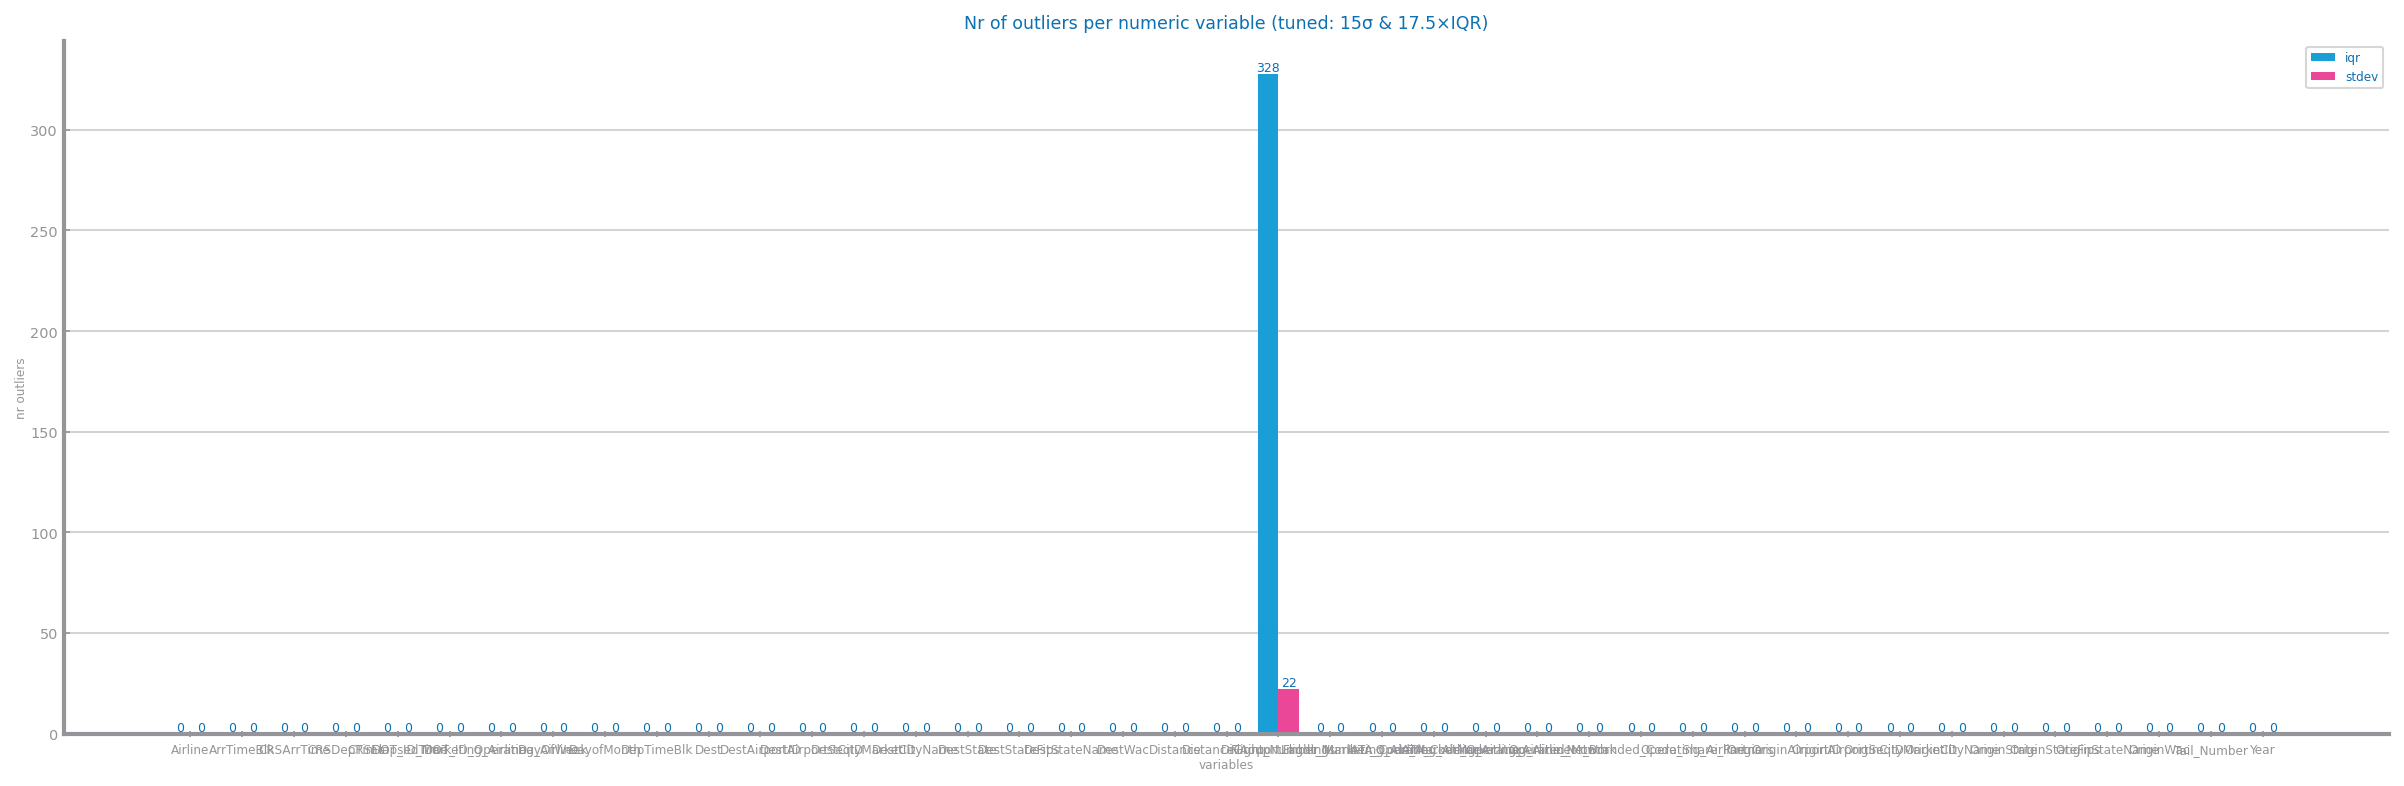


=== VARIABLES WITH OUTLIERS (TUNED THRESHOLDS) ===
Variable                                 | IQR Outliers | StDev Outliers
---------------------------------------------------------------------------
DivAirportLandings                       | 328          | 22            

(Only variables with > 0 outliers shown.)



In [9]:
file_tag = "flight_mvi1"

if numeric_vars:
    outliers_tuned = count_outliers(
        train_raw,
        numeric=numeric_vars,
        nrstdev=TUNED_NR_STDEV,
        iqrfactor=TUNED_IQR_FACTOR,
    )

    figure(figsize=(20, 6))
    plot_multibar_chart(
        numeric_vars,
        outliers_tuned,
        title=(
            f"Nr of outliers per numeric variable "
            f"(tuned: {TUNED_NR_STDEV}σ & {TUNED_IQR_FACTOR}×IQR)"
        ),
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    show()
else:
    print("There are no numeric variables.")


def list_variables_with_outliers(
    numeric_vars: list[str],
    outlier_dict: dict[str, list[int]]
):
    """
    Prints a readable list of variables with nonzero outliers
    according to both IQR and StDev tuned thresholds.
    """
    print("\n=== VARIABLES WITH OUTLIERS (TUNED THRESHOLDS) ===")
    print(f"{'Variable':40s} | {'IQR Outliers':12s} | {'StDev Outliers':14s}")
    print("-" * 75)

    for i, var in enumerate(numeric_vars):
        n_iqr   = outlier_dict["iqr"][i]
        n_stdev = outlier_dict["stdev"][i]

        if n_iqr > 0 or n_stdev > 0:
            print(f"{var:40s} | {n_iqr:<12d} | {n_stdev:<14d}")

    print("\n(Only variables with > 0 outliers shown.)\n")
list_variables_with_outliers(numeric_vars, outliers_tuned)


In [10]:
OUTLIER_VARS = [
    "DivAirportLandings",
]

# Outliers Method 1 (Drop)

In [11]:
def outlier_drop(
    train: DataFrame,
    test: DataFrame,
    outlier_vars: list[str],
    std_based: bool = False,          # False → use IQR-based thresholds
    nrstdev: float = TUNED_NR_STDEV,
    iqrfactor: float = TUNED_IQR_FACTOR,
) -> tuple[DataFrame, DataFrame]:
    """
    Method A – drop any record where one of OUTLIER_VARS is outside thresholds.
    Thresholds are computed ONLY on train, then applied to both train & test.
    """
    train = train.copy()
    test  = test.copy()

    # we only compute thresholds on numeric columns that are in outlier_vars
    numeric_cols = train.select_dtypes(include="number").columns.tolist()
    vars_to_use  = [v for v in outlier_vars if v in numeric_cols]

    if not vars_to_use:
        print("No outlier variables found in numeric columns. Returning unchanged.")
        return train, test

    summary5 = train[vars_to_use].describe()

    # start with all rows kept, then filter down
    mask_train = DataFrame(True, index=train.index, columns=["keep"])["keep"]
    mask_test  = DataFrame(True, index=test.index,  columns=["keep"])["keep"]

    for var in vars_to_use:
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var],
            std_based=std_based,
            threshold=(nrstdev if std_based else iqrfactor),
        )
        mask_train &= (train[var] <= top) & (train[var] >= bottom)
        mask_test  &= (test[var]  <= top) & (test[var]  >= bottom)

    train_out = train[mask_train].copy()
    test_out  = test[mask_test].copy()

    print(f"[outlier_drop] Train: {len(train)} → {len(train_out)}")
    print(f"[outlier_drop] Test:  {len(test)} → {len(test_out)}")

    return train_out, test_out

# Outlier Method 2 (Truncate)

In [12]:
def outlier_truncate(
    train: DataFrame,
    test: DataFrame,
    outlier_vars: list[str],
    std_based: bool = False,          # False → use IQR-based thresholds
    nrstdev: float = TUNED_NR_STDEV,
    iqrfactor: float = TUNED_IQR_FACTOR,
) -> tuple[DataFrame, DataFrame]:
    """
    Method B – truncate outliers:
      x < bottom → bottom
      x > top    → top
    Thresholds computed ONLY on train, applied to both train & test.
    """
    train = train.copy()
    test  = test.copy()

    numeric_cols = train.select_dtypes(include="number").columns.tolist()
    vars_to_use  = [v for v in outlier_vars if v in numeric_cols]

    if not vars_to_use:
        print("No outlier variables found in numeric columns. Returning unchanged.")
        return train, test

    summary5 = train[vars_to_use].describe()

    for var in vars_to_use:
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var],
            std_based=std_based,
            threshold=(nrstdev if std_based else iqrfactor),
        )

        # truncate / clip to [bottom, top]
        train[var] = train[var].clip(lower=bottom, upper=top)
        test[var]  = test[var].clip(lower=bottom, upper=top)

    print(f"[outlier_truncate] Applied truncation to: {vars_to_use}")

    return train, test

# Outlier Method 3 - Keep All

In [13]:
def outlier_none(train: DataFrame, test: DataFrame) -> tuple[DataFrame, DataFrame]:
    """
    Method C – no outlier treatment (just return copies).
    This is your baseline to compare against dropping/truncating.
    """
    return train.copy(), test.copy()

# Evaluation

In [14]:
train_none,  test_none  = outlier_none(train_raw, test_raw)
train_drop,  test_drop  = outlier_drop(
    train_raw, test_raw, OUTLIER_VARS,
    std_based=False, nrstdev=TUNED_NR_STDEV, iqrfactor=TUNED_IQR_FACTOR
)
train_trunc, test_trunc = outlier_truncate(
    train_raw, test_raw, OUTLIER_VARS,
    std_based=False, nrstdev=TUNED_NR_STDEV, iqrfactor=TUNED_IQR_FACTOR
)

print("NONE  shapes:",  train_none.shape,  test_none.shape)
print("DROP  shapes:",  train_drop.shape,  test_drop.shape)
print("TRUNC shapes:", train_trunc.shape, test_trunc.shape)

[outlier_drop] Train: 140000 → 139672
[outlier_drop] Test:  60000 → 59808
[outlier_truncate] Applied truncation to: ['DivAirportLandings']
NONE  shapes: (140000, 44) (60000, 44)
DROP  shapes: (139672, 44) (59808, 44)
TRUNC shapes: (140000, 44) (60000, 44)


In [19]:
file_tag_none  = "flight_outliers_none"
file_tag_drop  = "flight_outliers_drop"
file_tag_trunc = "flight_outliers_trunc"

# Columns to drop before modeling (datetime, etc.)
cols_to_drop = [
    "FlightDate",
]

# --- Build eval copies (drop only for modeling) ---

# NONE (baseline)
train_none_eval = train_none.drop(columns=cols_to_drop, errors="ignore").copy()
test_none_eval  = test_none.drop(columns=cols_to_drop, errors="ignore").copy()

# DROP outliers
train_drop_eval = train_drop.drop(columns=cols_to_drop, errors="ignore").copy()
test_drop_eval  = test_drop.drop(columns=cols_to_drop, errors="ignore").copy()

# TRUNCATE outliers
train_trunc_eval = train_trunc.drop(columns=cols_to_drop, errors="ignore").copy()
test_trunc_eval  = test_trunc.drop(columns=cols_to_drop, errors="ignore").copy()

# ensure target is int
for df in [
    train_none_eval,  test_none_eval,
    train_drop_eval,  test_drop_eval,
    train_trunc_eval, test_trunc_eval,
]:
    df[target] = df[target].astype(int)


# ========= same evaluate_approach + print_eval_table as other notebooks =========

def evaluate_approach(
    train: DataFrame,
    test: DataFrame,
    target: str = "Cancelled",
    metric: str = "recall",
) -> dict[str, list[float]]:
    """
    Same shape as professor's function:
      eval[metric_name] = [NB_value, KNN_value]
    ready for plot_multibar_chart(["NB","KNN"], eval, ...).
    """
    trn = train.copy()
    tst = test.copy()

    trnY = trn.pop(target).values
    trnX: ndarray = trn.values
    tstY = tst.pop(target).values
    tstX: ndarray = tst.values

    eval_dict: dict[str, list[float]] = {}

    eval_NB  = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN = run_KNN(trnX, trnY, tstX, tstY, metric=metric)

    if eval_NB and eval_KNN:
        for met in CLASS_EVAL_METRICS:
            eval_dict[met] = [eval_NB[met], eval_KNN[met]]

    return eval_dict


def print_eval_table(eval_dict: dict[str, list[float]], label: str):
    """
    Pretty-print evaluation metrics for NB and KNN with 4 decimal places.
    """
    print(f"\n=== MODEL METRIC SUMMARY (NB vs KNN) — {label} ===")
    print(f"{'Metric':12s} | {'NB':>10s} | {'KNN':>10s}")
    print("-" * 40)
    for metric, vals in eval_dict.items():
        nb, knn = vals
        print(f"{metric:12s} | {nb:10.4f} | {knn:10.4f}")
    print()


=== OUTLIERS EVALUATION (NB + KNN) ===

=== MODEL METRIC SUMMARY (NB vs KNN) — NONE (baseline) ===
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.5696 |     0.9524
recall       |     0.5322 |     0.0909
precision    |     0.0278 |     0.0702
auc          |     0.5513 |     0.5316
f1           |     0.0528 |     0.0793



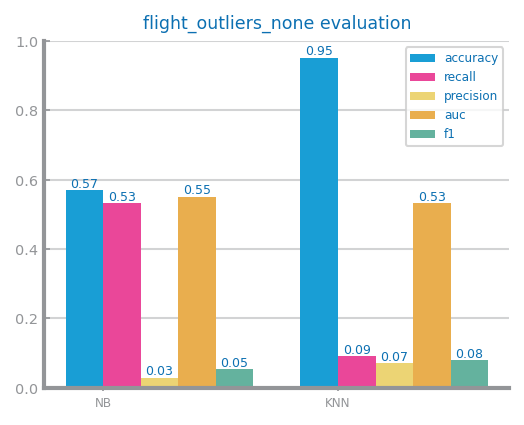


=== MODEL METRIC SUMMARY (NB vs KNN) — DROP OUTLIERS ===
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.5684 |     0.9527
recall       |     0.5301 |     0.0922
precision    |     0.0275 |     0.0716
auc          |     0.5497 |     0.5323
f1           |     0.0524 |     0.0806



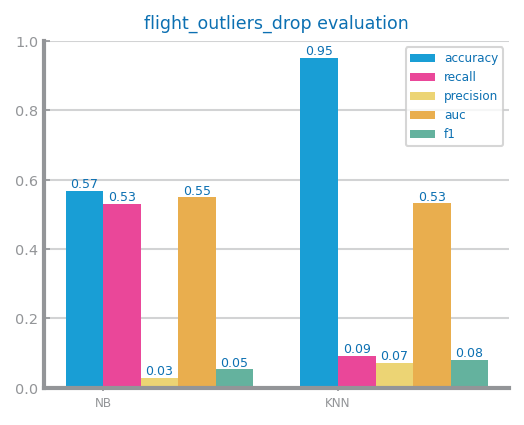


=== MODEL METRIC SUMMARY (NB vs KNN) — TRUNCATE OUTLIERS ===
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.5696 |     0.9524
recall       |     0.5314 |     0.0909
precision    |     0.0278 |     0.0702
auc          |     0.5509 |     0.5316
f1           |     0.0527 |     0.0793



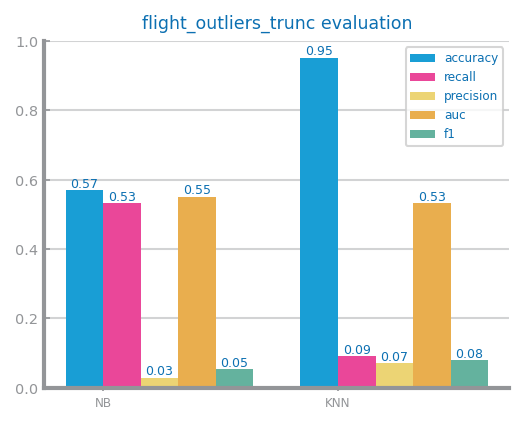

In [20]:
print("\n=== OUTLIERS EVALUATION (NB + KNN) ===")

# --- NONE (baseline) ---
figure()
eval_none = evaluate_approach(
    train_none_eval.copy(),
    test_none_eval.copy(),
    target=target,
    metric="recall",
)
print_eval_table(eval_none, "NONE (baseline)")
plot_multibar_chart(
    ["NB", "KNN"],
    eval_none,
    title=f"{file_tag_none} evaluation",
    percentage=True,
)
savefig(f"../../charts/lab3_preparation/{file_tag_none}_NB_KNN_recall_eval.png")
show()

# --- DROP OUTLIERS ---
figure()
eval_drop = evaluate_approach(
    train_drop_eval.copy(),
    test_drop_eval.copy(),
    target=target,
    metric="recall",
)
print_eval_table(eval_drop, "DROP OUTLIERS")
plot_multibar_chart(
    ["NB", "KNN"],
    eval_drop,
    title=f"{file_tag_drop} evaluation",
    percentage=True,
)
savefig(f"../../charts/lab3_preparation/{file_tag_drop}_NB_KNN_recall_eval.png")
show()

# --- TRUNCATE OUTLIERS ---
figure()
eval_trunc = evaluate_approach(
    train_trunc_eval.copy(),
    test_trunc_eval.copy(),
    target=target,
    metric="recall",
)
print_eval_table(eval_trunc, "TRUNCATE OUTLIERS")
plot_multibar_chart(
    ["NB", "KNN"],
    eval_trunc,
    title=f"{file_tag_trunc} evaluation",
    percentage=True,
)
savefig(f"../../charts/lab3_preparation/{file_tag_trunc}_NB_KNN_recall_eval.png")
show()

In [22]:
file_tag    = "flight_outliers_none"
target      = "Cancelled"
eval_metric = "recall"

# Use the BEST outlier strategy → NONE
train_df = train_none_eval.copy()
test_df  = test_none_eval.copy()

trnY = train_df[target].values
tstY = test_df[target].values

trnX = train_df.drop(columns=[target]).values
tstX = test_df.drop(columns=[target]).values

labels = sorted(list(set(trnY) | set(tstY)))
print(f"Train#={len(trnX)}  Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=140000  Test#=60000
Labels=[np.int64(0), np.int64(1)]


<Figure size 600x450 with 0 Axes>

Best NB params: {'name': 'MultinomialNB', 'metric': 'recall', 'params': (), 'recall': 0.532150776053215}


<Figure size 600x450 with 0 Axes>

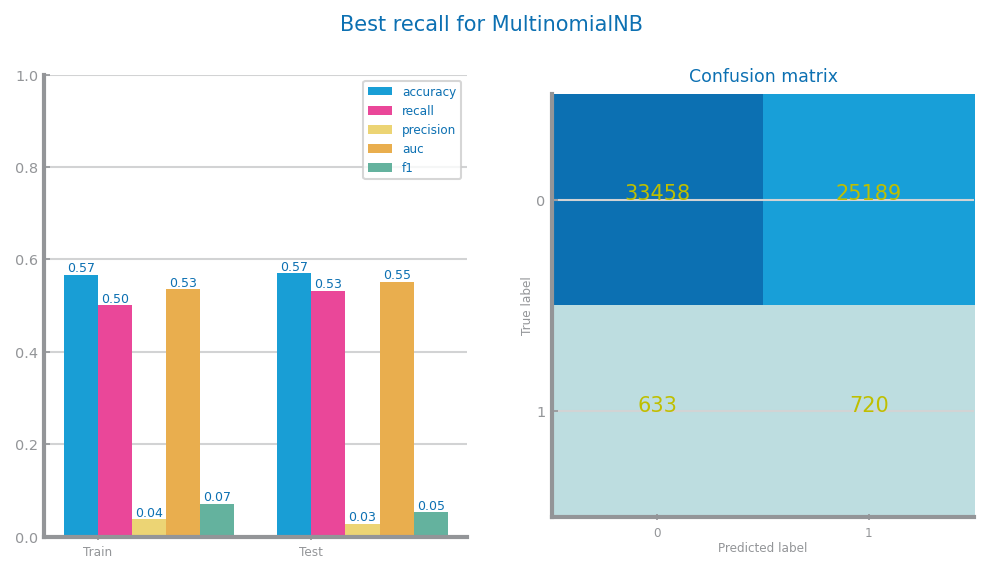

In [23]:
def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list[str] = []
    yvalues: list[float] = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance: float = 0.0

    for clf_name in estimators:
        xvalues.append(clf_name)
        clf = estimators[clf_name]
        clf.fit(trnX, trnY)
        prdY: array = clf.predict(tstX)
        eval_val: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval_val - best_performance > DELTA_IMPROVE:
            best_performance = eval_val
            best_params["name"] = clf_name
            best_params[metric] = eval_val
            best_model = clf
        yvalues.append(eval_val)

    return best_model, best_params

# ---- NB study on OUTLIER-NONE dataset ----
figure()
best_nb_model, nb_params = naive_Bayes_study(trnX, trnY, tstX, tstY, metric=eval_metric)
savefig(f"../../charts/lab3_preparation/{file_tag}_nb_{eval_metric}_study.png")
show()

print("Best NB params:", nb_params)

# ---- NB confusion matrix + metrics ----
prd_trn_nb: array = best_nb_model.predict(trnX)
prd_tst_nb: array = best_nb_model.predict(tstX)

figure()
plot_evaluation_results(nb_params, trnY, prd_trn_nb, tstY, prd_tst_nb, labels)
savefig(f"../../charts/lab3_preparation/{file_tag}_nb_{nb_params['name']}_best_{nb_params['metric']}_eval.png")
show()


KNN best with k=3 and chebyshev (recall=0.0288)


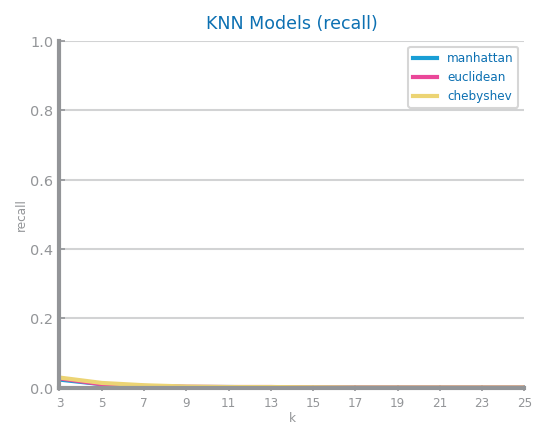

<Figure size 600x450 with 0 Axes>

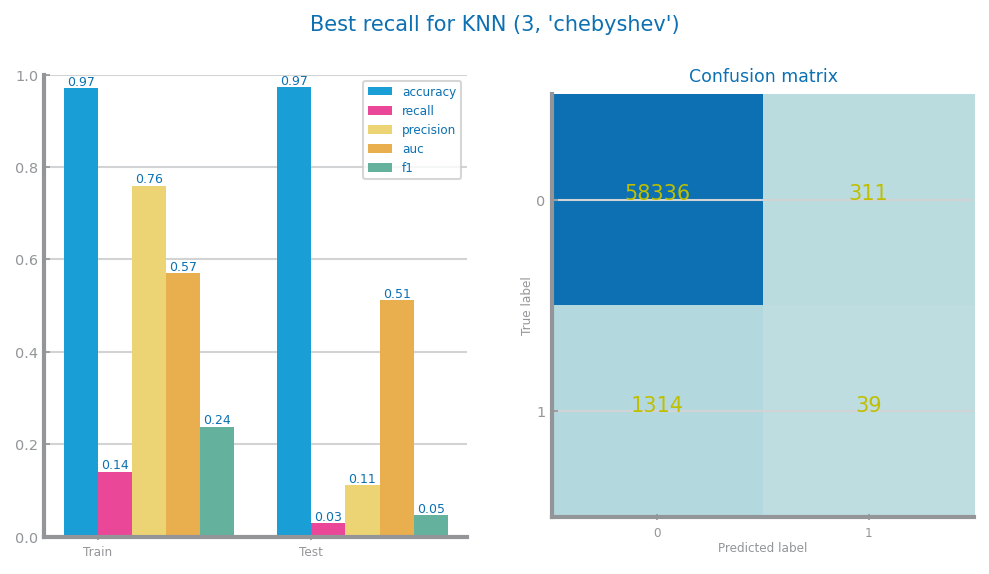

In [24]:
def knn_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    k_max: int = 10,
    lag: int = 2,
    metric: str = "recall",
    k_min: int = 3,
) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal["manhattan", "euclidean", "chebyshev"]] = [
        "manhattan",
        "euclidean",
        "chebyshev",
    ]

    kvalues: list[int] = [k for k in range(k_min, k_max + 1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {"name": "KNN", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list[float] = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval_val: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval_val)
            if eval_val - best_performance > DELTA_IMPROVE:
                best_performance = eval_val
                best_params["params"] = (k, d)
                best_model = clf
        values[d] = y_tst_values

    print(
        f'KNN best with k={best_params["params"][0]} and '
        f'{best_params["params"][1]} ({metric}={best_performance:.4f})'
    )

    plot_multiline_chart(
        kvalues,
        values,
        title=f"KNN Models ({metric})",
        xlabel="k",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params

# ---- KNN param search + study plot on OUTLIER-NONE ----
figure()
best_knn, knn_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
# savefig(f"../../charts/lab3_preparation/{file_tag}_knn_{eval_metric}_study.png")
# show()

# ---- KNN confusion matrix + metrics ----
prd_trn_knn = best_knn.predict(trnX)
prd_tst_knn = best_knn.predict(tstX)

figure()
plot_evaluation_results(
    knn_params,
    trnY,
    prd_trn_knn,
    tstY,
    prd_tst_knn,
    labels,
)
savefig(f"../../charts/lab3_preparation/{file_tag}_knn_{knn_params['name']}_best_{knn_params['metric']}_eval.png")
show()


# Saving Updated Data with Best Method

In [25]:
input_path  = "../../data/prepared/flight_mvi.csv"
output_path = "../../data/prepared/flight_outliers.csv"
target = "Cancelled"

print("Reading MVI-treated data from:", input_path)
full_raw = read_csv(input_path, na_values="")
print("Original shape:", full_raw.shape)

# Outlier method chosen: NONE
# So we simply save the dataset as-is.
full_outliers = full_raw.copy()

full_outliers.to_csv(output_path, index=False)

print("\nSaved full NO-OUTLIER dataset →", output_path)
print("Final shape:", full_outliers.shape)
print("Columns:", list(full_outliers.columns))

Reading MVI-treated data from: ../../data/prepared/flight_mvi.csv
Original shape: (200000, 44)

Saved full NO-OUTLIER dataset → ../../data/prepared/flight_outliers.csv
Final shape: (200000, 44)
Columns: ['Airline', 'ArrTimeBlk', 'CRSArrTime', 'CRSDepTime', 'CRSElapsedTime', 'DOT_ID_Marketing_Airline', 'DOT_ID_Operating_Airline', 'DayOfWeek', 'DayofMonth', 'DepTimeBlk', 'Dest', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'Distance', 'DistanceGroup', 'DivAirportLandings', 'FlightDate', 'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline', 'IATA_Code_Marketing_Airline', 'IATA_Code_Operating_Airline', 'Marketing_Airline_Network', 'Month', 'Operated_or_Branded_Code_Share_Partners', 'Operating_Airline', 'Origin', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'Quarter', 'Tail_Number', 'Year',